**TPRAC with UPRAC Results**

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

multi_cores_out_path = '../../TPRAC_ISCA2025/4cores_results'

df = pd.DataFrame(columns=["mitigation", "workload"])
df_baseline = pd.DataFrame(columns=["mitigation", "workload"])

mitigation_list = ["Baseline", "ABO-Only", 'BAT-RFM', 'TPRAC-S']
for mitigation in mitigation_list:
    result_path = multi_cores_out_path + "/" + mitigation +"/stats/"
    result_list = [x[:-4] for x in os.listdir(result_path) if x.endswith(".txt")]
    for result_filename in result_list:
        result_file = open(result_path + result_filename + ".txt", "r")
        if mitigation in ['Baseline']:
            Channel = int(result_filename.split("_")[0])
            interface = int(result_filename.split("_")[1])
            workload = "_".join(result_filename.split("_")[2:])
        else:
            Channel = int(result_filename.split("_")[0])
            interface = int(result_filename.split("_")[1])
            NRH = int(result_filename.split("_")[2])
            if NRH ==128:
                continue
            PRAC_level = int(result_filename.split("_")[3])
            workload = "_".join(result_filename.split("_")[4:])

        w0=''
        w1=''
        w2=''
        w3=''
        ipc_0 = 0
        ipc_1 = 0
        ipc_2 = 0
        ipc_3 = 0
        cycle_0 = 0
        cycle_1 = 0
        cycle_2 = 0
        cycle_3 = 0
        num_inst_0=0
        num_inst_1=0
        num_inst_2=0
        num_inst_3=0
        num_rd_reqs=0
        num_wr_reqs=0
        wr_reqs_ratio = 0.0
        # num_tREFI_period=0
        # num_tREFW_period=0
        for line in result_file.readlines():
            if ("name_trace_0:" in line):
                w0 = str(line.split("/")[-1]).strip()
            if ("name_trace_1:" in line):
                w1 = str(line.split("/")[-1]).strip()
            if ("name_trace_2:" in line):
                w2 = str(line.split("/")[-1]).strip()
            if ("name_trace_3:" in line):
                w3 = str(line.split("/")[-1]).strip()
            if (" cycles_recorded_core_0:" in line):
                cycle_0 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_1:" in line):
                cycle_1 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_2:" in line):
                cycle_2 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_3:" in line):
                cycle_3 = int(line.split(" ")[-1])
            if (" insts_recorded_core_0" in line):
                num_inst_0 = int(line.split(" ")[-1])
            if (" insts_recorded_core_1" in line):
                num_inst_1 = int(line.split(" ")[-1])
            if (" insts_recorded_core_2" in line):
                num_inst_2 = int(line.split(" ")[-1])
            if (" insts_recorded_core_3" in line):
                num_inst_3 = int(line.split(" ")[-1])
            if (" total_num_read_requests" in line):
                num_rd_reqs = int(line.split(" ")[-1])
            if (" total_num_write_requests" in line):
                num_wr_reqs = int(line.split(" ")[-1])
            # if (" prac_num_recovery" in line):
            #     num_abo = int(line.split(" ")[-1])
            # if (" num_refresh_command_0" in line):
            #     num_tREFI_period = int(line.split(" ")[-1])
            # if (" num_refresh_window_0" in line):
            #     num_tREFW_period = int(line.split(" ")[-1])            
                
        if (cycle_0 == 0 and cycle_1 == 0 and cycle_2 == 0 and cycle_3 == 0):
            continue
        if (cycle_0 == 0 or cycle_1 == 0 or cycle_2 == 0 or cycle_3 == 0):
            print("Error: " + result_filename)
        ipc_0 = int(num_inst_0) / cycle_0
        ipc_1 = int(num_inst_1) / cycle_1
        ipc_2 = int(num_inst_2) / cycle_2
        ipc_3 = int(num_inst_3) / cycle_3
        
        wr_reqs_ratio = float(int(num_wr_reqs)/int(num_rd_reqs + num_wr_reqs))
        result_file.close()
        # Create a new DataFrame for the new row
        if mitigation in ["Baseline"]:
            new_row = pd.DataFrame({
                'mitigation': [mitigation],
                'workload': [workload],
                'wl0': [w0],
                'wl1': [w1],
                'wl2': [w2],
                'wl3': [w3],
                'ipc0': [ipc_0],
                'ipc1': [ipc_1],
                'ipc2': [ipc_2],
                'ipc3': [ipc_3],
            })
            df_baseline = pd.concat([df_baseline, new_row], ignore_index=True)
        else:
            new_row = pd.DataFrame({
                'mitigation': [mitigation],
                'workload': [workload],
                'Channel': [Channel],
                'interface': [interface],
                'Nrh': [NRH],
                'prac-level': [PRAC_level],
                'wl0': [w0],
                'wl1': [w1],
                'wl2': [w2],
                'wl3': [w3],
                'ipc0': [ipc_0],
                'ipc1': [ipc_1],
                'ipc2': [ipc_2],
                'ipc3': [ipc_3],
            })
            df = pd.concat([df, new_row], ignore_index=True)

### Read Baseline Single Core ipc
df_sc_ipc = pd.read_csv('../stats/SC_500M_DDR5_8000_PRAC_Baseline.csv')
# Choose only interested baseline
df_sc_ipc = df_sc_ipc[['workload', 'Channel', 'interface', 'Baseline']]
df_sc_ipc = df_sc_ipc[(df_sc_ipc['interface'] == 8000)]
df_sc_ipc = df_sc_ipc.drop(columns=['Channel', 'interface'])
df_sc_ipc = df_sc_ipc.rename(columns={'workload': 'workload_sc'})

# First, merge df with df_sc_ipc for each workload (wl0, wl1, wl2, wl3)
df = df.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl0'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl0'})
df_baseline = df_baseline.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl0'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl0'})
if 'workload_sc' in df.columns:
    df = df.drop(columns=['workload_sc'])  # Drop 'workload' if it exists
    df_baseline = df_baseline.drop(columns=['workload_sc'])  # Drop 'workload' if it exists

df = df.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl1'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl1'})
df_baseline = df_baseline.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl1'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl1'})
if 'workload_sc' in df.columns:
    df = df.drop(columns=['workload_sc'])  # Drop 'workload' again if it exists
    df_baseline = df_baseline.drop(columns=['workload_sc'])  # Drop 'workload' again if it exists

df = df.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl2'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl2'})
df_baseline = df_baseline.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl2'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl2'})
if 'workload_sc' in df.columns:
    df = df.drop(columns=['workload_sc'])  # Drop 'workload' again if it exists
    df_baseline = df_baseline.drop(columns=['workload_sc'])  # Drop 'workload' again if it exists

df = df.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl3'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl3'})
df_baseline = df_baseline.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl3'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl3'})
if 'workload_sc' in df.columns:
    df = df.drop(columns=['workload_sc'])  # Final cleanup
    df_baseline = df_baseline.drop(columns=['workload_sc'])  # Final cleanup

df['normalzied_ipc0'] = df['ipc0'] / df['ipc_wl0']
df['normalzied_ipc1'] = df['ipc1'] / df['ipc_wl1']
df['normalzied_ipc2'] = df['ipc2'] / df['ipc_wl2']
df['normalzied_ipc3'] = df['ipc3'] / df['ipc_wl3']

df_baseline['normalzied_ipc0'] = df_baseline['ipc0'] / df_baseline['ipc_wl0']
df_baseline['normalzied_ipc1'] = df_baseline['ipc1'] / df_baseline['ipc_wl1']
df_baseline['normalzied_ipc2'] = df_baseline['ipc2'] / df_baseline['ipc_wl2']
df_baseline['normalzied_ipc3'] = df_baseline['ipc3'] / df_baseline['ipc_wl3']

df['WS'] = df[['normalzied_ipc0', 'normalzied_ipc1', 'normalzied_ipc2', 'normalzied_ipc3']].sum(axis=1)
df_baseline['WS'] = df_baseline[['normalzied_ipc0', 'normalzied_ipc1', 'normalzied_ipc2', 'normalzied_ipc3']].sum(axis=1)


df_closed_cap1_ws = df[['mitigation', 'workload', 'Nrh', 'prac-level', 'WS']]
df_baseline_ws = df_baseline[['mitigation', 'workload','WS']]

merged_df = pd.merge(df_closed_cap1_ws, df_baseline_ws[['workload', 'WS']], on='workload', how='left', suffixes=('', '_baseline'))
# Calculate normalized WS
merged_df['normalized_WS'] = merged_df['WS'] / merged_df['WS_baseline']

merged_df_pivot = merged_df.pivot(index=['workload','Nrh', 'prac-level'], columns=['mitigation'], values='normalized_WS').reset_index()

##### Calculate the Geomean for each workload type
# Define benchmark suites and their corresponding workloads ranges
benchmark_types = {
    'HHHH (15)': list(range(0, 15)),   # From Mix0-Mix14
    'MMMM (15)': list(range(15, 30)),  # From Mix15-Mix29
    'LLLL (15)': list(range(30, 45)),  # From Mix30-Mix44
    'HHMM (15)': list(range(45, 60)),  # From Mix45-Mix59
    'HHLL (15)': list(range(60, 75)),  # From Mix60-Mix74
    'MMLL (15)': list(range(75, 90)),  # From Mix75-Mix89
}

# DataFrame Example (you already have your df)
# Assuming your column of interest is 'PRAC_WO_Mitigation-ClosedCap1'

# Add a new column to assign each Mix to the appropriate suite
def assign_benchmark_types(mix_index):
    for suite, mix_range in benchmark_types.items():
        if mix_index in mix_range:
            return suite
    return None

# Assuming 'workload' has values like 'MIX0', 'MIX1', etc., you can extract the index
merged_df_pivot['Mix_index'] = merged_df_pivot['workload'].str.extract(r'(\d+)').astype(int)  # Extract Mix number
merged_df_pivot['Benchmark_Types'] = merged_df_pivot['Mix_index'].apply(assign_benchmark_types)  # Assign benchmark suite

# Function to calculate the geometric mean
def calculate_geometric_mean(series):
    return np.exp(np.log(series).mean())

def add_geomean_rows(df):
    geomean_rows = []  # List to collect new rows
    for Nrh in df['Nrh'].unique():
        for prac_level in df['prac-level'].unique():
            for suite_name, mix_indices in benchmark_types.items():
                # Create a list of corresponding workload names (e.g., MIX0, MIX1)
                workloads = [f'MIX{i}' for i in mix_indices]
                suite_df = df[(df['workload'].isin(workloads)) & 
                                (df['Nrh'] == Nrh) & 
                                (df['prac-level'] == prac_level)]
                if not suite_df.empty:
                    geomeans = {}
                    
                    # Dynamically calculate geometric means for each mitigation
                    for mitigation in mitigation_list:
                        geomeans[mitigation] = calculate_geometric_mean(suite_df[mitigation])
                    
                    # Create a new row
                    geomean_row = {'workload': suite_name, 'Nrh': Nrh, 'prac-level': prac_level, **geomeans}
                    geomean_rows.append(geomean_row)  # Append to the list

    # Convert list of rows to DataFrame
    geomean_df = pd.DataFrame(geomean_rows)
    
    return pd.concat([df, geomean_df], ignore_index=True)

def add_all_workloads_geomean_rows(df):
    geomean_rows = []  # List to collect new rows
    
    for Nrh in df['Nrh'].unique():
        for prac_level in df['prac-level'].unique():
            Channel_df = df[(df['Nrh'] == Nrh) & 
                                (df['prac-level'] == prac_level)]
            geomean_values = {}
            
            # Calculate geometric means for each mitigation in the list
            for mitigation in mitigation_list:
                if mitigation in Channel_df.columns:  # Ensure the column exists
                    geomean_values[mitigation] = calculate_geometric_mean(Channel_df[mitigation])

            # Create a new row for the combined results
            geomean_row = {'workload': 'All (90)', 'Nrh': Nrh, 'prac-level': prac_level, **geomean_values}
            geomean_rows.append(geomean_row)  # Append to the list
    
    # Convert list of rows to DataFrame
    geomean_df = pd.DataFrame(geomean_rows)
    
    return pd.concat([df, geomean_df], ignore_index=True)


mitigation_list = ["ABO-Only", 'BAT-RFM', 'TPRAC-S']


geomean_df = add_geomean_rows(merged_df_pivot)
geomean_df = add_all_workloads_geomean_rows(geomean_df)
print(geomean_df)
geomean_df[['workload', 'Nrh', 'prac-level', "Benchmark_Types", "ABO-Only", 'BAT-RFM', 'TPRAC-S']].to_csv('../stats/4cores_500M_TPRAC_S_Result.csv', index=False)


     workload     Nrh  prac-level  ABO-Only   BAT-RFM   TPRAC-S  Mix_index  \
0        MIX0   256.0         1.0  0.999957       NaN       NaN        0.0   
1        MIX0   512.0         1.0  1.000050  0.939064       NaN        0.0   
2        MIX0   512.0         2.0  0.999954  0.939064       NaN        0.0   
3        MIX0   512.0         4.0  0.999782  0.939064       NaN        0.0   
4        MIX0  1024.0         1.0  0.999996  0.989666       NaN        0.0   
..        ...     ...         ...       ...       ...       ...        ...   
682  All (90)  2048.0         2.0       NaN       NaN       NaN        NaN   
683  All (90)  2048.0         4.0       NaN       NaN       NaN        NaN   
684  All (90)  4096.0         1.0  1.000000  0.997221  0.990952        NaN   
685  All (90)  4096.0         2.0       NaN       NaN       NaN        NaN   
686  All (90)  4096.0         4.0       NaN       NaN       NaN        NaN   

    Benchmark_Types  
0         HHHH (15)  
1         HHHH (15)

**Performance Main Figure**

['C059', 'C059', 'C059', 'C059', 'D050000L', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'Liberation Mono', 'Liberation Mono', 'Liberation Mono', 'Liberation Mono', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'P052', 'P052', 'P052', 'P052', 'STIXGeneral', 'STIXGeneral', 'STIXGeneral', 'STIXGeneral', 'STIXNonUnicode', 'STIXNonUnicode', '

/tmp/ipykernel_2386750/2821352082.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_random = df_melted.groupby('Benchmark_Types', group_keys=False).apply(


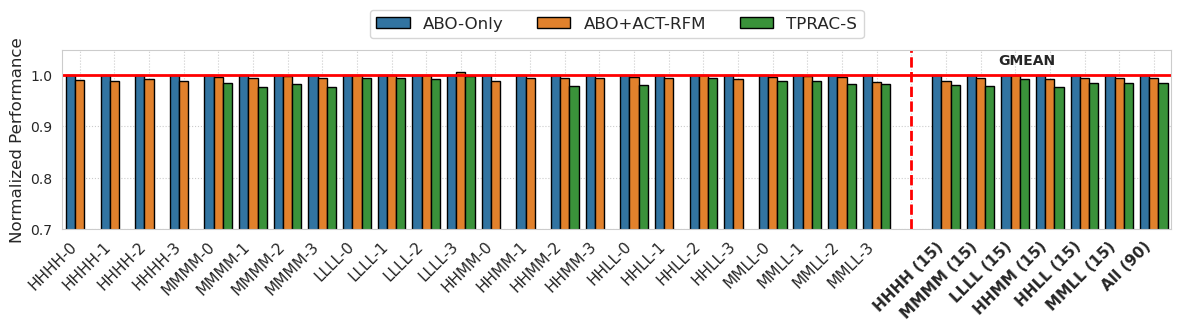

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm

# List all available font names
available_fonts = sorted([f.name for f in fm.fontManager.ttflist])
print(available_fonts)

df_ws_nrh_1024 = pd.read_csv('../stats/4cores_500M_TPRAC_S_Result.csv')
df_ws_nrh_1024 = df_ws_nrh_1024[(df_ws_nrh_1024['Nrh'] == 1024) & (df_ws_nrh_1024['prac-level'] == 1)]

mitigation_interest = ["ABO-Only", 'BAT-RFM', 'TPRAC-S']

df_melted = pd.melt(
    df_ws_nrh_1024, 
    id_vars=['workload', 'Benchmark_Types'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)

#### For renaming mitigations
rename_mapping = {
    'BAT-RFM': 'ABO+ACT-RFM',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)

# Define the list of Benchmark_Types
benchmark_types = ['HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)']


# Define the list of workloads you want to add
geomean_workloads = [
    'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 
    'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)'
]
# Group by Benchmark_Types and randomly sample 5 rows for each group
df_random = df_melted.groupby('Benchmark_Types', group_keys=False).apply(
    lambda x: x.loc[x['workload'].isin(x['workload'].drop_duplicates().sample(n=5, random_state=42))]
).reset_index(drop=True)

# Filter the rows in df_melted that match the specified workloads
df_workloads = df_melted[df_melted['workload'].isin(geomean_workloads)]

#Step 1 Rename workloads based on the Benchmark_Types
df_random_renamed = df_random.copy()

# Group by 'Benchmark_Types' to handle each group separately
for benchmark in df_random_renamed['Benchmark_Types'].unique():
    # Get the rows for the current benchmark type
    benchmark_data = df_random_renamed[df_random_renamed['Benchmark_Types'] == benchmark]
    
    # Get the unique workloads for this benchmark type
    unique_workloads = benchmark_data['workload'].unique()
    
    # Sort the workloads and create a new name based on the index
    workload_mapping = {workload: f"{benchmark.split(' ')[0]}-{i}" for i, workload in enumerate(unique_workloads)}
    
    # Apply the new names to the 'workload' column for the current benchmark type
    df_random_renamed.loc[df_random_renamed['Benchmark_Types'] == benchmark, 'workload'] = df_random_renamed['workload'].map(workload_mapping)

# Now concatenate these rows with df_random5
df_random_extended = pd.concat([df_random_renamed, df_workloads], ignore_index=True)

## Preprocessing df_filtered
# Filter the data to show the results only for Med and High MPKI
xticks_order =  ['HHHH-0', 'HHHH-1', 'HHHH-2', 'HHHH-3',  

                 'MMMM-0', 'MMMM-1', 'MMMM-2', 'MMMM-3', 

                 'LLLL-0', 'LLLL-1', 'LLLL-2', 'LLLL-3', 

                 'HHMM-0', 'HHMM-1', 'HHMM-2', 'HHMM-3', 

                 'HHLL-0', 'HHLL-1', 'HHLL-2', 'HHLL-3', 

                 'MMLL-0', 'MMLL-1', 'MMLL-2', 'MMLL-3', 
                 ' ',
                 'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 
                 'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)' 
                 ]

df_ordered = df_random_extended[df_random_extended['workload'].isin(xticks_order)]

# Set here again if we have changed the name
mitigation_interest = ["ABO-Only", 'ABO+ACT-RFM', 'TPRAC-S']
df_filtered = df_ordered[df_ordered['Mitigations'].isin(mitigation_interest)]
df_filtered['Mitigations'] = pd.Categorical(df_filtered['Mitigations'], categories=mitigation_interest, ordered=True)

# #### Prepare plotting
# Sort workloads by Benchmark_Types first to ensure the correct order
sns.set_palette('tab10')
sns.set_style("whitegrid")

# Set the global font family
plt.rcParams['font.family'] = 'DejaVu Sans'  # Change to your desired font

fig, ax = plt.subplots(figsize=(12,3.7))
plt.rc('font', size=10)


ax = sns.barplot(x='workload', y='WS',hue='Mitigations', order=xticks_order, data=df_filtered, edgecolor='black')

ax.set_xticks(np.arange(len(xticks_order)))
ax.set_xticklabels(xticks_order, ha='right', rotation=45, fontsize = 11)

# Get the positions of the x-ticks
tick_labels = ax.get_xticklabels()

# Find the positions of geomean labels
geomean_labels = ['HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)',  'All (90)']
for tick_label in tick_labels:
    if tick_label.get_text() in geomean_labels:
        tick_label.set_fontweight('bold')

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
ax.axvline(24, 0, 1, color='red', linestyle = '--', linewidth=2)
ax.text(26.5, 1.02, 'GMEAN', fontweight='bold')

ax.set_xlabel('')
ax.set_ylabel('Normalized Performance', fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.27), ncol=5, fancybox=True, shadow=False, fontsize=12)


ax.set_ylim(0.7,1.05)

plt.grid(True, linestyle=':')
plt.tight_layout()
fig.savefig('../plots/TPRAC_ISCA2025/TPRAC_Nrh1024_performance.pdf', dpi=600, bbox_inches='tight')

**NRH = 512**

['C059', 'C059', 'C059', 'C059', 'D050000L', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'Liberation Mono', 'Liberation Mono', 'Liberation Mono', 'Liberation Mono', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'P052', 'P052', 'P052', 'P052', 'STIXGeneral', 'STIXGeneral', 'STIXGeneral', 'STIXGeneral', 'STIXNonUnicode', 'STIXNonUnicode', '

/tmp/ipykernel_2386750/2226537498.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_random = df_melted.groupby('Benchmark_Types', group_keys=False).apply(


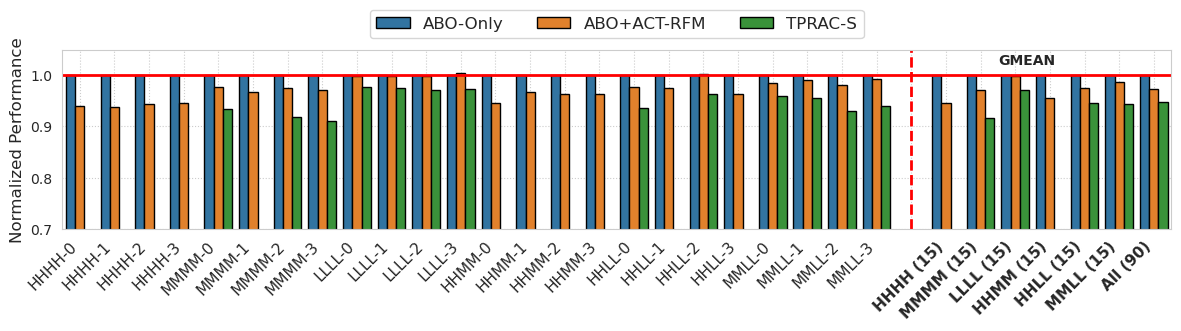

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm

# List all available font names
available_fonts = sorted([f.name for f in fm.fontManager.ttflist])
print(available_fonts)

df_ws_nrh_512 = pd.read_csv('../stats/4cores_500M_TPRAC_S_Result.csv')
df_ws_nrh_512 = df_ws_nrh_512[(df_ws_nrh_512['Nrh'] == 512) & (df_ws_nrh_512['prac-level'] == 1)]

mitigation_interest = ["ABO-Only", 'BAT-RFM', 'TPRAC-S']

df_melted = pd.melt(
    df_ws_nrh_512, 
    id_vars=['workload', 'Benchmark_Types'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)

#### For renaming mitigations
rename_mapping = {
    'BAT-RFM': 'ABO+ACT-RFM',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)

# Define the list of Benchmark_Types
benchmark_types = ['HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)']


# Define the list of workloads you want to add
geomean_workloads = [
    'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 
    'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)'
]
# Group by Benchmark_Types and randomly sample 5 rows for each group
df_random = df_melted.groupby('Benchmark_Types', group_keys=False).apply(
    lambda x: x.loc[x['workload'].isin(x['workload'].drop_duplicates().sample(n=5, random_state=42))]
).reset_index(drop=True)

# Filter the rows in df_melted that match the specified workloads
df_workloads = df_melted[df_melted['workload'].isin(geomean_workloads)]

#Step 1 Rename workloads based on the Benchmark_Types
df_random_renamed = df_random.copy()

# Group by 'Benchmark_Types' to handle each group separately
for benchmark in df_random_renamed['Benchmark_Types'].unique():
    # Get the rows for the current benchmark type
    benchmark_data = df_random_renamed[df_random_renamed['Benchmark_Types'] == benchmark]
    
    # Get the unique workloads for this benchmark type
    unique_workloads = benchmark_data['workload'].unique()
    
    # Sort the workloads and create a new name based on the index
    workload_mapping = {workload: f"{benchmark.split(' ')[0]}-{i}" for i, workload in enumerate(unique_workloads)}
    
    # Apply the new names to the 'workload' column for the current benchmark type
    df_random_renamed.loc[df_random_renamed['Benchmark_Types'] == benchmark, 'workload'] = df_random_renamed['workload'].map(workload_mapping)

# Now concatenate these rows with df_random5
df_random_extended = pd.concat([df_random_renamed, df_workloads], ignore_index=True)

## Preprocessing df_filtered
# Filter the data to show the results only for Med and High MPKI
xticks_order =  ['HHHH-0', 'HHHH-1', 'HHHH-2', 'HHHH-3',  

                 'MMMM-0', 'MMMM-1', 'MMMM-2', 'MMMM-3', 

                 'LLLL-0', 'LLLL-1', 'LLLL-2', 'LLLL-3', 

                 'HHMM-0', 'HHMM-1', 'HHMM-2', 'HHMM-3', 

                 'HHLL-0', 'HHLL-1', 'HHLL-2', 'HHLL-3', 

                 'MMLL-0', 'MMLL-1', 'MMLL-2', 'MMLL-3', 
                 ' ',
                 'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 
                 'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)' 
                 ]

df_ordered = df_random_extended[df_random_extended['workload'].isin(xticks_order)]

# Set here again if we have changed the name
mitigation_interest = ["ABO-Only", 'ABO+ACT-RFM', 'TPRAC-S']
df_filtered = df_ordered[df_ordered['Mitigations'].isin(mitigation_interest)]
df_filtered['Mitigations'] = pd.Categorical(df_filtered['Mitigations'], categories=mitigation_interest, ordered=True)

# #### Prepare plotting
# Sort workloads by Benchmark_Types first to ensure the correct order
sns.set_palette('tab10')
sns.set_style("whitegrid")

# Set the global font family
plt.rcParams['font.family'] = 'DejaVu Sans'  # Change to your desired font

fig, ax = plt.subplots(figsize=(12,3.7))
plt.rc('font', size=10)


ax = sns.barplot(x='workload', y='WS',hue='Mitigations', order=xticks_order, data=df_filtered, edgecolor='black')

ax.set_xticks(np.arange(len(xticks_order)))
ax.set_xticklabels(xticks_order, ha='right', rotation=45, fontsize = 11)

# Get the positions of the x-ticks
tick_labels = ax.get_xticklabels()

# Find the positions of geomean labels
geomean_labels = ['HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)',  'All (90)']
for tick_label in tick_labels:
    if tick_label.get_text() in geomean_labels:
        tick_label.set_fontweight('bold')

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
ax.axvline(24, 0, 1, color='red', linestyle = '--', linewidth=2)
ax.text(26.5, 1.02, 'GMEAN', fontweight='bold')

ax.set_xlabel('')
ax.set_ylabel('Normalized Performance', fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.27), ncol=5, fancybox=True, shadow=False, fontsize=12)


ax.set_ylim(0.7,1.05)

plt.grid(True, linestyle=':')
plt.tight_layout()
fig.savefig('../plots/TPRAC_ISCA2025/TPRAC_Nrh512_performance.pdf', dpi=600, bbox_inches='tight')

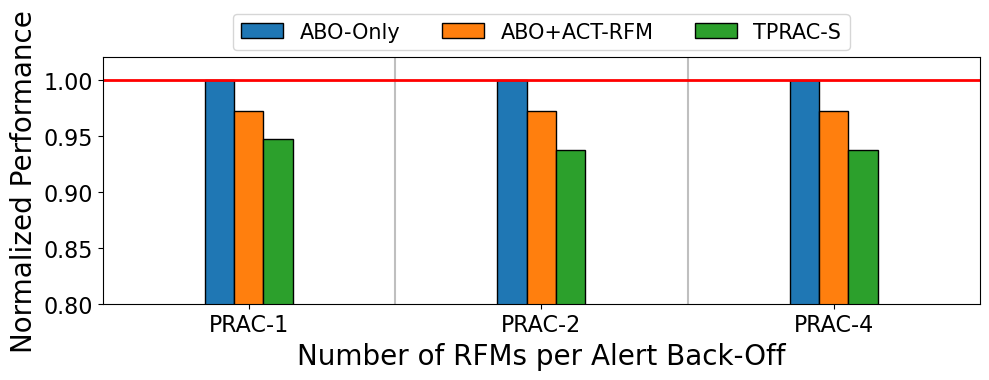

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm



df_prac_level_study = pd.read_csv('../stats/4cores_500M_TPRAC_S_Result.csv')
df_prac_level_study = df_prac_level_study[(df_prac_level_study['Nrh'] == 512) & (df_prac_level_study['workload'] == 'All (90)')]
mitigation_interest = ["ABO-Only", 'BAT-RFM', 'TPRAC-S']

df_melted = pd.melt(
    df_prac_level_study, 
    id_vars=['workload', 'Benchmark_Types', 'Nrh', 'prac-level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
#### For renaming mitigations
rename_mapping = {
    'BAT-RFM': 'ABO+ACT-RFM',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)
# Calculate performance overhead
df_melted['Performance_Overhead'] = (1 - df_melted['WS'])*100

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 4))
plt.rc('font', size=10)
# Use Seaborn's 'tab10' color palette
palette = sns.color_palette("tab10")
colors = {impl: palette[i % len(palette)] for i, impl in enumerate(df_melted['Mitigations'].unique())}


# Define bar width and x-tick positions
bar_width = 0.1  # Desired smaller bar width
x_ticks = [1, 2, 4]
num_bars = len(df_melted['Mitigations'].unique())
# Create a mapping for x-tick labels
x_tick_labels = {1: 'PRAC-1', 2: 'PRAC-2', 4: 'PRAC-4'}
# Calculate positions for bars
# x_tick_positions = np.arange(len(x_ticks))  # Positions for x-ticks
x_tick_positions = np.linspace(0, len(x_ticks) - 1, len(x_ticks))  # Adjust spacing here
bar_positions = {}

# Calculate bar positions
for idx, tick in enumerate(x_ticks):
    base_x = x_tick_positions[idx]
    bar_positions[tick] = [base_x - (bar_width * num_bars) / 2 + j * bar_width for j in range(num_bars)]

# Plot bars
for tick in x_ticks:
    subset = df_melted[df_melted['prac-level'] == tick]
    for i, prac_impl in enumerate(df_melted['Mitigations'].unique()):
        value = subset[subset['Mitigations'] == prac_impl]['WS'].values[0]
        x_position = bar_positions[tick][i] + bar_width / 2  # Adjust position for centering
        color = colors[prac_impl]
        ax.bar(x_position, value, width=bar_width, color=color, edgecolor='black', label=prac_impl if tick == x_ticks[0] else "")

# Add a horizontal line at y=1.0
# ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)

# Customize legend, labels, and ticks
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels from the legend
# ax.legend(by_label.values(), by_label.keys(), loc='best', ncol=3, fancybox=True, shadow=False, fontsize=16)

# Set xticks to specific num_RFM values and ensure correct spacing
ax.set_xticks(x_tick_positions)
ax.set_xticklabels([x_tick_labels[tick] for tick in x_ticks])  # Use mapped labels
ax.axvline(x=0.5, color='grey', linestyle='-', alpha=0.5)
ax.axvline(x=1.5, color='grey', linestyle='-', alpha=0.5)
ax.set_xlabel('Number of RFMs per Alert Back-Off', fontsize=20)
ax.set_ylabel('Normalized Performance', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=5, fancybox=True, shadow=False, fontsize=15)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)

ax.set_ylim(0.8,1.02)
ax.set_xlim(-0.5, 2.5)

plt.tight_layout()
# plt.show()
fig.savefig('../plots/TPRAC_ISCA2025/TPRAC_prac_level_sensitivity.pdf', dpi=600, bbox_inches='tight')

     workload     Nrh  prac-level Benchmark_Types  ABO-Only   BAT-RFM  \
672  All (90)   256.0         1.0             NaN  0.999824  0.939854   
675  All (90)   512.0         1.0             NaN  0.999978  0.972286   
678  All (90)  1024.0         1.0             NaN  0.999993  0.994513   
681  All (90)  2048.0         1.0             NaN  1.000000  0.997221   
684  All (90)  4096.0         1.0             NaN  1.000000  0.997221   

      TPRAC-S  
672  0.893285  
675  0.946906  
678  0.985271  
681  0.990952  
684  0.990952  


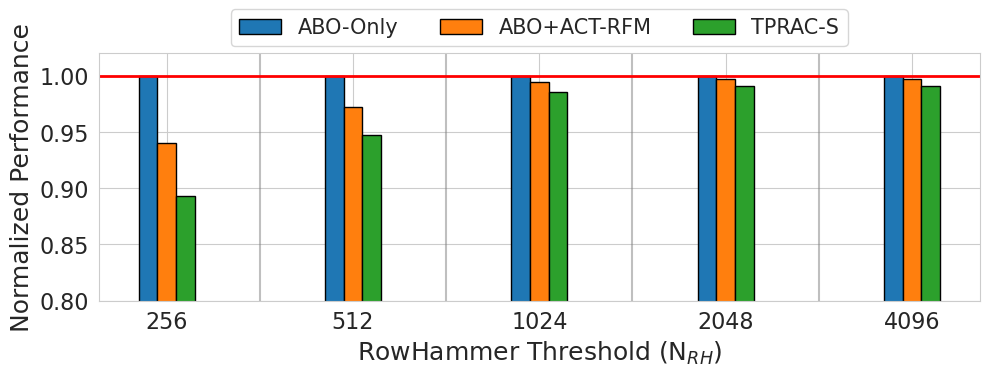

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm



df_prac_level_study = pd.read_csv('../stats/4cores_500M_TPRAC_S_Result.csv')
df_prac_level_study = df_prac_level_study[(df_prac_level_study['Nrh'].isin([256, 512, 1024, 2048, 4096])) &
                                          (df_prac_level_study['prac-level'] == 1) &
                                           (df_prac_level_study['workload'] == 'All (90)')]
print(df_prac_level_study)
mitigation_interest = ["ABO-Only", 'BAT-RFM', 'TPRAC-S']

df_melted = pd.melt(
    df_prac_level_study, 
    id_vars=['workload', 'Benchmark_Types', 'Nrh', 'prac-level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
#### For renaming mitigations
rename_mapping = {
    'BAT-RFM': 'ABO+ACT-RFM',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)
# Calculate performance overhead
df_melted['Performance_Overhead'] = (1 - df_melted['WS'])*100

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 4))
plt.rc('font', size=10)
# Use Seaborn's 'tab10' color palette
palette = sns.color_palette("tab10")
colors = {impl: palette[i % len(palette)] for i, impl in enumerate(df_melted['Mitigations'].unique())}


# Define bar width and x-tick positions
bar_width = 0.1  # Desired smaller bar width
x_ticks = [256, 512, 1024, 2048, 4096]
num_bars = len(df_melted['Mitigations'].unique())

x_tick_positions = np.linspace(0, len(x_ticks) - 1, len(x_ticks))  # Adjust spacing here
bar_positions = {}

# Calculate bar positions
for idx, tick in enumerate(x_ticks):
    base_x = x_tick_positions[idx]
    bar_positions[tick] = [base_x - (bar_width * num_bars) / 2 + j * bar_width for j in range(num_bars)]

# Plot bars
for tick in x_ticks:
    subset = df_melted[df_melted['Nrh'] == tick]
    for i, prac_impl in enumerate(df_melted['Mitigations'].unique()):
        value = subset[subset['Mitigations'] == prac_impl]['WS'].values[0]
        x_position = bar_positions[tick][i] + bar_width / 2  # Adjust position for centering
        color = colors[prac_impl]
        ax.bar(x_position, value, width=bar_width, color=color, edgecolor='black', label=prac_impl if tick == x_ticks[0] else "")

# Add a horizontal line at y=1.0
# ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
# Add vertical lines for better visual separation
trh_values = np.sort(df_melted['Nrh'].unique())
for i in range(len(trh_values) - 1):
    ax.axvline(x=i + 0.5, color='grey', linestyle='-', alpha=0.5)

# Customize legend, labels, and ticks
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels from the legend
# ax.legend(by_label.values(), by_label.keys(), loc='best', ncol=3, fancybox=True, shadow=False, fontsize=16)

# Set xticks to specific num_RFM values and ensure correct spacing
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_ticks)

ax.set_xlabel('RowHammer Threshold (N$_{RH}$)', fontsize=18)
ax.set_ylabel('Normalized Performance', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=5, fancybox=True, shadow=False, fontsize=15)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)

ax.set_ylim(0.8,1.02)
# ax.set_xlim(-0.5, 2.5)

plt.tight_layout()
# plt.show()
fig.savefig('../plots/TPRAC_ISCA2025/TPRAC_NRH_sensitivity.pdf', dpi=600, bbox_inches='tight')

**Performance with MOAT**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

multi_cores_out_path = '../../TPRAC_ISCA2025/4cores_results'

df = pd.DataFrame(columns=["mitigation", "workload"])
df_baseline = pd.DataFrame(columns=["mitigation", "workload"])

mitigation_list = ["Baseline", "QPRAC-ABO-Only", 'QPRAC-BAT-RFM', 'QPRAC-TPRAC-S']
for mitigation in mitigation_list:
    result_path = multi_cores_out_path + "/" + mitigation +"/stats/"
    result_list = [x[:-4] for x in os.listdir(result_path) if x.endswith(".txt")]
    for result_filename in result_list:
        result_file = open(result_path + result_filename + ".txt", "r")
        if mitigation in ['Baseline']:
            Channel = int(result_filename.split("_")[0])
            interface = int(result_filename.split("_")[1])
            workload = "_".join(result_filename.split("_")[2:])
        else:
            Channel = int(result_filename.split("_")[0])
            interface = int(result_filename.split("_")[1])
            NRH = int(result_filename.split("_")[2])
            if NRH == 128:
                continue
            PRAC_level = int(result_filename.split("_")[3])
            workload = "_".join(result_filename.split("_")[4:])

        w0=''
        w1=''
        w2=''
        w3=''
        ipc_0 = 0
        ipc_1 = 0
        ipc_2 = 0
        ipc_3 = 0
        cycle_0 = 0
        cycle_1 = 0
        cycle_2 = 0
        cycle_3 = 0
        num_inst_0=0
        num_inst_1=0
        num_inst_2=0
        num_inst_3=0
        num_rd_reqs=0
        num_wr_reqs=0
        wr_reqs_ratio = 0.0
        # num_tREFI_period=0
        # num_tREFW_period=0
        for line in result_file.readlines():
            if ("name_trace_0:" in line):
                w0 = str(line.split("/")[-1]).strip()
            if ("name_trace_1:" in line):
                w1 = str(line.split("/")[-1]).strip()
            if ("name_trace_2:" in line):
                w2 = str(line.split("/")[-1]).strip()
            if ("name_trace_3:" in line):
                w3 = str(line.split("/")[-1]).strip()
            if (" cycles_recorded_core_0:" in line):
                cycle_0 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_1:" in line):
                cycle_1 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_2:" in line):
                cycle_2 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_3:" in line):
                cycle_3 = int(line.split(" ")[-1])
            if (" insts_recorded_core_0" in line):
                num_inst_0 = int(line.split(" ")[-1])
            if (" insts_recorded_core_1" in line):
                num_inst_1 = int(line.split(" ")[-1])
            if (" insts_recorded_core_2" in line):
                num_inst_2 = int(line.split(" ")[-1])
            if (" insts_recorded_core_3" in line):
                num_inst_3 = int(line.split(" ")[-1])
            if (" total_num_read_requests" in line):
                num_rd_reqs = int(line.split(" ")[-1])
            if (" total_num_write_requests" in line):
                num_wr_reqs = int(line.split(" ")[-1])
            # if (" prac_num_recovery" in line):
            #     num_abo = int(line.split(" ")[-1])
            # if (" num_refresh_command_0" in line):
            #     num_tREFI_period = int(line.split(" ")[-1])
            # if (" num_refresh_window_0" in line):
            #     num_tREFW_period = int(line.split(" ")[-1])            
                
        if (cycle_0 == 0 and cycle_1 == 0 and cycle_2 == 0 and cycle_3 == 0):
            continue
        if (cycle_0 == 0 or cycle_1 == 0 or cycle_2 == 0 or cycle_3 == 0):
            print("Error: " + result_filename)
        ipc_0 = int(num_inst_0) / cycle_0
        ipc_1 = int(num_inst_1) / cycle_1
        ipc_2 = int(num_inst_2) / cycle_2
        ipc_3 = int(num_inst_3) / cycle_3
        
        wr_reqs_ratio = float(int(num_wr_reqs)/int(num_rd_reqs + num_wr_reqs))
        result_file.close()
        # Create a new DataFrame for the new row
        if mitigation in ["Baseline"]:
            new_row = pd.DataFrame({
                'mitigation': [mitigation],
                'workload': [workload],
                'wl0': [w0],
                'wl1': [w1],
                'wl2': [w2],
                'wl3': [w3],
                'ipc0': [ipc_0],
                'ipc1': [ipc_1],
                'ipc2': [ipc_2],
                'ipc3': [ipc_3],
            })
            df_baseline = pd.concat([df_baseline, new_row], ignore_index=True)
        else:
            new_row = pd.DataFrame({
                'mitigation': [mitigation],
                'workload': [workload],
                'Channel': [Channel],
                'interface': [interface],
                'Nrh': [NRH],
                'prac-level': [PRAC_level],
                'wl0': [w0],
                'wl1': [w1],
                'wl2': [w2],
                'wl3': [w3],
                'ipc0': [ipc_0],
                'ipc1': [ipc_1],
                'ipc2': [ipc_2],
                'ipc3': [ipc_3],
            })
            df = pd.concat([df, new_row], ignore_index=True)

### Read Baseline Single Core ipc
df_sc_ipc = pd.read_csv('../stats/SC_500M_DDR5_8000_PRAC_Baseline.csv')
# Choose only interested baseline
df_sc_ipc = df_sc_ipc[['workload', 'Channel', 'interface', 'Baseline']]
df_sc_ipc = df_sc_ipc[(df_sc_ipc['interface'] == 8000)]
df_sc_ipc = df_sc_ipc.drop(columns=['Channel', 'interface'])
df_sc_ipc = df_sc_ipc.rename(columns={'workload': 'workload_sc'})

# First, merge df with df_sc_ipc for each workload (wl0, wl1, wl2, wl3)
df = df.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl0'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl0'})
df_baseline = df_baseline.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl0'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl0'})
if 'workload_sc' in df.columns:
    df = df.drop(columns=['workload_sc'])  # Drop 'workload' if it exists
    df_baseline = df_baseline.drop(columns=['workload_sc'])  # Drop 'workload' if it exists

df = df.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl1'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl1'})
df_baseline = df_baseline.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl1'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl1'})
if 'workload_sc' in df.columns:
    df = df.drop(columns=['workload_sc'])  # Drop 'workload' again if it exists
    df_baseline = df_baseline.drop(columns=['workload_sc'])  # Drop 'workload' again if it exists

df = df.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl2'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl2'})
df_baseline = df_baseline.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl2'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl2'})
if 'workload_sc' in df.columns:
    df = df.drop(columns=['workload_sc'])  # Drop 'workload' again if it exists
    df_baseline = df_baseline.drop(columns=['workload_sc'])  # Drop 'workload' again if it exists

df = df.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl3'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl3'})
df_baseline = df_baseline.merge(df_sc_ipc[['workload_sc', 'Baseline']], left_on=['wl3'], right_on=['workload_sc'], how='left').rename(columns={'Baseline': 'ipc_wl3'})
if 'workload_sc' in df.columns:
    df = df.drop(columns=['workload_sc'])  # Final cleanup
    df_baseline = df_baseline.drop(columns=['workload_sc'])  # Final cleanup

df['normalzied_ipc0'] = df['ipc0'] / df['ipc_wl0']
df['normalzied_ipc1'] = df['ipc1'] / df['ipc_wl1']
df['normalzied_ipc2'] = df['ipc2'] / df['ipc_wl2']
df['normalzied_ipc3'] = df['ipc3'] / df['ipc_wl3']

df_baseline['normalzied_ipc0'] = df_baseline['ipc0'] / df_baseline['ipc_wl0']
df_baseline['normalzied_ipc1'] = df_baseline['ipc1'] / df_baseline['ipc_wl1']
df_baseline['normalzied_ipc2'] = df_baseline['ipc2'] / df_baseline['ipc_wl2']
df_baseline['normalzied_ipc3'] = df_baseline['ipc3'] / df_baseline['ipc_wl3']

df['WS'] = df[['normalzied_ipc0', 'normalzied_ipc1', 'normalzied_ipc2', 'normalzied_ipc3']].sum(axis=1)
df_baseline['WS'] = df_baseline[['normalzied_ipc0', 'normalzied_ipc1', 'normalzied_ipc2', 'normalzied_ipc3']].sum(axis=1)


df_closed_cap1_ws = df[['mitigation', 'workload', 'Nrh', 'prac-level', 'WS']]
df_baseline_ws = df_baseline[['mitigation', 'workload','WS']]

merged_df = pd.merge(df_closed_cap1_ws, df_baseline_ws[['workload', 'WS']], on='workload', how='left', suffixes=('', '_baseline'))
# Calculate normalized WS
merged_df['normalized_WS'] = merged_df['WS'] / merged_df['WS_baseline']

merged_df_pivot = merged_df.pivot(index=['workload','Nrh', 'prac-level'], columns=['mitigation'], values='normalized_WS').reset_index()

##### Calculate the Geomean for each workload type
# Define benchmark suites and their corresponding workloads ranges
benchmark_types = {
    'HHHH (15)': list(range(0, 15)),   # From Mix0-Mix14
    'MMMM (15)': list(range(15, 30)),  # From Mix15-Mix29
    'LLLL (15)': list(range(30, 45)),  # From Mix30-Mix44
    'HHMM (15)': list(range(45, 60)),  # From Mix45-Mix59
    'HHLL (15)': list(range(60, 75)),  # From Mix60-Mix74
    'MMLL (15)': list(range(75, 90)),  # From Mix75-Mix89
}

# DataFrame Example (you already have your df)
# Assuming your column of interest is 'PRAC_WO_Mitigation-ClosedCap1'

# Add a new column to assign each Mix to the appropriate suite
def assign_benchmark_types(mix_index):
    for suite, mix_range in benchmark_types.items():
        if mix_index in mix_range:
            return suite
    return None

# Assuming 'workload' has values like 'MIX0', 'MIX1', etc., you can extract the index
merged_df_pivot['Mix_index'] = merged_df_pivot['workload'].str.extract(r'(\d+)').astype(int)  # Extract Mix number
merged_df_pivot['Benchmark_Types'] = merged_df_pivot['Mix_index'].apply(assign_benchmark_types)  # Assign benchmark suite

# Function to calculate the geometric mean
def calculate_geometric_mean(series):
    return np.exp(np.log(series).mean())

def add_geomean_rows(df):
    geomean_rows = []  # List to collect new rows
    for Nrh in df['Nrh'].unique():
        for prac_level in df['prac-level'].unique():
            for suite_name, mix_indices in benchmark_types.items():
                # Create a list of corresponding workload names (e.g., MIX0, MIX1)
                workloads = [f'MIX{i}' for i in mix_indices]
                suite_df = df[(df['workload'].isin(workloads)) & 
                                (df['Nrh'] == Nrh) & 
                                (df['prac-level'] == prac_level)]
                if not suite_df.empty:
                    geomeans = {}
                    
                    # Dynamically calculate geometric means for each mitigation
                    for mitigation in mitigation_list:
                        geomeans[mitigation] = calculate_geometric_mean(suite_df[mitigation])
                    
                    # Create a new row
                    geomean_row = {'workload': suite_name, 'Nrh': Nrh, 'prac-level': prac_level, **geomeans}
                    geomean_rows.append(geomean_row)  # Append to the list

    # Convert list of rows to DataFrame
    geomean_df = pd.DataFrame(geomean_rows)
    
    return pd.concat([df, geomean_df], ignore_index=True)

def add_all_workloads_geomean_rows(df):
    geomean_rows = []  # List to collect new rows
    
    for Nrh in df['Nrh'].unique():
        for prac_level in df['prac-level'].unique():
            Channel_df = df[(df['Nrh'] == Nrh) & 
                                (df['prac-level'] == prac_level)]
            geomean_values = {}
            
            # Calculate geometric means for each mitigation in the list
            for mitigation in mitigation_list:
                if mitigation in Channel_df.columns:  # Ensure the column exists
                    geomean_values[mitigation] = calculate_geometric_mean(Channel_df[mitigation])

            # Create a new row for the combined results
            geomean_row = {'workload': 'All (90)', 'Nrh': Nrh, 'prac-level': prac_level, **geomean_values}
            geomean_rows.append(geomean_row)  # Append to the list
    
    # Convert list of rows to DataFrame
    geomean_df = pd.DataFrame(geomean_rows)
    
    return pd.concat([df, geomean_df], ignore_index=True)


mitigation_list = ["QPRAC-ABO-Only", 'QPRAC-BAT-RFM', 'QPRAC-TPRAC-S']


geomean_df = add_geomean_rows(merged_df_pivot)
geomean_df = add_all_workloads_geomean_rows(geomean_df)
print(geomean_df)
geomean_df[['workload', 'Nrh', 'prac-level', "Benchmark_Types", "QPRAC-ABO-Only", 'QPRAC-BAT-RFM', 'QPRAC-TPRAC-S']].to_csv('../stats/4cores_500M_TPRAC_S_Result_with_QPRAC.csv', index=False)


     workload     Nrh  prac-level  QPRAC-ABO-Only  QPRAC-BAT-RFM  \
0        MIX0   256.0         1.0        0.999935       0.834580   
1        MIX0   512.0         1.0        1.000050       0.939064   
2        MIX0   512.0         2.0        0.999954       0.939064   
3        MIX0   512.0         4.0        0.999782       0.939064   
4        MIX0  1024.0         1.0        0.999996       0.989666   
..        ...     ...         ...             ...            ...   
874  All (90)  2048.0         2.0             NaN            NaN   
875  All (90)  2048.0         4.0             NaN            NaN   
876  All (90)  4096.0         1.0        1.000000       0.997221   
877  All (90)  4096.0         2.0             NaN            NaN   
878  All (90)  4096.0         4.0             NaN            NaN   

     QPRAC-TPRAC-S  Mix_index Benchmark_Types  
0         0.805437        0.0       HHHH (15)  
1         0.902182        0.0       HHHH (15)  
2         0.902182        0.0       HHH

['434-520-470-483', '433-450-429-549', '433-483-437-520', '437-433-429-459', '471-434-450-483', '437-459-549-471', '519-450-437-520', '433-434-429-520', '519-549-459-437', '433-459-471-549', '483-519-437-470', '429-470-450-434', '520-433-483-471', '483-549-434-433', '459-437-470-520', '549-471-473-462', '471-429-tpch17-wc_map', '519-470-tpch2-436', '450-437-462-grep_map', '520-429-tpcc64-tpch2', ' ', 'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)']


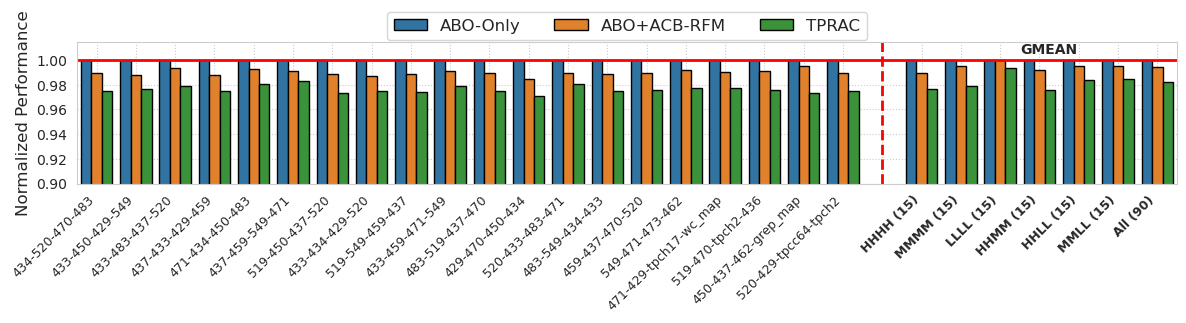

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm

# List all available font names
available_fonts = sorted([f.name for f in fm.fontManager.ttflist])
# print(available_fonts)

df_ws_nrh_1024 = pd.read_csv('../stats/4cores_500M_TPRAC_S_Result_with_QPRAC.csv')
df_ws_nrh_1024 = df_ws_nrh_1024[(df_ws_nrh_1024['Nrh'] == 1024) & (df_ws_nrh_1024['prac-level'] == 1)]

mitigation_interest = ["QPRAC-ABO-Only", 'QPRAC-BAT-RFM', 'QPRAC-TPRAC-S']

df_melted = pd.melt(
    df_ws_nrh_1024, 
    id_vars=['workload', 'Benchmark_Types', 'Nrh', 'prac-level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
### For renaming mitigations
rename_mapping = {
    'QPRAC-ABO-Only': 'ABO-Only',
    'QPRAC-BAT-RFM': 'ABO+ACB-RFM',
    'QPRAC-TPRAC-S': 'TPRAC',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)

# Define the list of Benchmark_Types
benchmark_types = ['HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)']


# Define the list of workloads you want to add
geomean_workloads = [
    'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 
    'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)'
]

# Filter the rows in df_melted that match the specified workloads
df_workloads = df_melted[df_melted['workload'].isin(geomean_workloads)]

## Preprocessing df_filtered
# Filter the data to show the results only for Med and High MPKI
xticks_order =  ['MIX0', 'MIX1', 'MIX2', 'MIX3', 'MIX4', 'MIX5', 'MIX6', 'MIX7', 'MIX8', 'MIX9', 'MIX10', 
                 'MIX11', 'MIX12', 'MIX13', 'MIX14', 'MIX46', 'MIX48', 'MIX49', 'MIX50', 'MIX52',
                 ' ',
                 'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 
                 'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)' 
                 ]

df_ordered = df_melted[df_melted['workload'].isin(xticks_order)]


# Dictionary mapping MIX labels to workload combinations
mix_workloads = {
    'MIX0': '434-520-470-483',
    'MIX1': '433-450-429-549',
    'MIX2': '433-483-437-520',
    'MIX3': '437-433-429-459',
    'MIX4': '471-434-450-483',
    'MIX5': '437-459-549-471',
    'MIX6': '519-450-437-520',
    'MIX7': '433-434-429-520',
    'MIX8': '519-549-459-437',
    'MIX9': '433-459-471-549',
    'MIX10': '483-519-437-470',
    'MIX11': '429-470-450-434',
    'MIX12': '520-433-483-471',
    'MIX13': '483-549-434-433',
    'MIX14': '459-437-470-520',
    'MIX46': '549-471-473-462',
    'MIX48': '471-429-tpch17-wc_map',
    'MIX49': '519-470-tpch2-436',
    'MIX50': '450-437-462-grep_map',
    'MIX52': '520-429-tpcc64-tpch2',
}


# Update the xticks_order list
xticks_order_updated = [
    mix_workloads.get(tick, tick) for tick in xticks_order
]

# Print the updated list
print(xticks_order_updated)

# Set here again if we have changed the name
mitigation_interest = ["ABO-Only", 'ABO+ACB-RFM', 'TPRAC']
df_filtered = df_ordered[df_ordered['Mitigations'].isin(mitigation_interest)]
df_filtered['Mitigations'] = pd.Categorical(df_filtered['Mitigations'], categories=mitigation_interest, ordered=True)

df_filtered.to_csv('../stats/TPRAC_Results_Plots.csv', index=False)
# #### Prepare plotting
# Sort workloads by Benchmark_Types first to ensure the correct order
sns.set_palette('tab10')
sns.set_style("whitegrid")

# Set the global font family
plt.rcParams['font.family'] = 'DejaVu Sans'  # Change to your desired font

fig, ax = plt.subplots(figsize=(12,3.7))
plt.rc('font', size=10)


ax = sns.barplot(x='workload', y='WS',hue='Mitigations', order=xticks_order, data=df_filtered, edgecolor='black')

ax.set_xticks(np.arange(len(xticks_order)))
ax.set_xticklabels(xticks_order_updated, ha='right', rotation=45, fontsize = 11)

# Get the positions of the x-ticks
tick_labels = ax.get_xticklabels()

# Find the positions of geomean labels
geomean_labels = ['HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)',  'All (90)']
for tick_label in tick_labels:
    if tick_label.get_text() in geomean_labels:
        tick_label.set_fontweight('bold')

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
ax.axvline(20, 0, 1, color='red', linestyle = '--', linewidth=2)
ax.text(23.5, 1.005, 'GMEAN', fontweight='bold')
ax.set_yticks([0.9, 0.92, 0.94, 0.96, 0.98, 1.0])
ax.set_xlabel('')
ax.set_ylabel('Normalized Performance', fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.27), ncol=5, fancybox=True, shadow=False, fontsize=12)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.tick_params(axis='y', which='major', labelsize=10)

ax.set_ylim(0.9,1.015)

plt.grid(True, linestyle=':')
plt.tight_layout()
fig.savefig('../plots/TPRAC_ISCA2025/TPRAC_Nrh1024_performance.svg', dpi=600, bbox_inches='tight')

['C059', 'C059', 'C059', 'C059', 'D050000L', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'Liberation Mono', 'Liberation Mono', 'Liberation Mono', 'Liberation Mono', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Mono PS', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Roman', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'Nimbus Sans Narrow', 'P052', 'P052', 'P052', 'P052', 'STIXGeneral', 'STIXGeneral', 'STIXGeneral', 'STIXGeneral', 'STIXNonUnicode', 'STIXNonUnicode', '

/tmp/ipykernel_618996/3237138926.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_random = df_melted.groupby('Benchmark_Types', group_keys=False).apply(


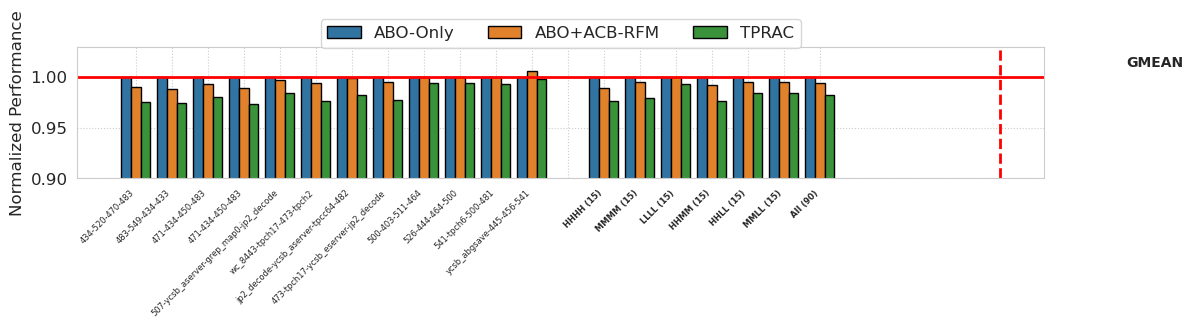

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm

# List all available font names
available_fonts = sorted([f.name for f in fm.fontManager.ttflist])
print(available_fonts)

df_ws_nrh_512 = pd.read_csv('../stats/4cores_500M_TPRAC_S_Result_with_QPRAC.csv')
df_ws_nrh_512 = df_ws_nrh_512[(df_ws_nrh_512['Nrh'] == 1024) & (df_ws_nrh_512['prac-level'] == 1)]

mitigation_interest = ["QPRAC-ABO-Only", 'QPRAC-BAT-RFM', 'QPRAC-TPRAC-S']

df_melted = pd.melt(
    df_ws_nrh_512, 
    id_vars=['workload', 'Benchmark_Types', 'Nrh', 'prac-level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
### For renaming mitigations
rename_mapping = {
    'QPRAC-ABO-Only': 'ABO-Only',
    'QPRAC-BAT-RFM': 'ABO+ACB-RFM',
    'QPRAC-TPRAC-S': 'TPRAC',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)


# Define the list of Benchmark_Types
benchmark_types = ['HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)']


# Define the list of workloads you want to add
geomean_workloads = [
    'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 
    'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)'
]
# Group by Benchmark_Types and randomly sample 5 rows for each group
df_random = df_melted.groupby('Benchmark_Types', group_keys=False).apply(
    lambda x: x.loc[x['workload'].isin(x['workload'].drop_duplicates().sample(n=5, random_state=42))]
).reset_index(drop=True)

# Filter the rows in df_melted that match the specified workloads
df_workloads = df_melted[df_melted['workload'].isin(geomean_workloads)]

#Step 1 Rename workloads based on the Benchmark_Types
df_random_renamed = df_random.copy()
original_workload_mapping = {}

# Group by 'Benchmark_Types' to handle each group separately
for benchmark in df_random_renamed['Benchmark_Types'].unique():
    # Get the rows for the current benchmark type
    benchmark_data = df_random_renamed[df_random_renamed['Benchmark_Types'] == benchmark]
    
    # Get the unique workloads for this benchmark type
    unique_workloads = benchmark_data['workload'].unique()
    
    # Sort the workloads and create a new name based on the index
    workload_mapping = {workload: f"{benchmark.split(' ')[0]}-{i}" for i, workload in enumerate(unique_workloads)}

    # Store original names in the dictionary before applying the new names
    for workload, renamed_workload in workload_mapping.items():
        original_workload_mapping[renamed_workload] = workload

    # Apply the new names to the 'workload' column for the current benchmark type
    df_random_renamed.loc[df_random_renamed['Benchmark_Types'] == benchmark, 'workload'] = df_random_renamed['workload'].map(workload_mapping)
# Check the randomly selected workloads in df_random
print(original_workload_mapping)

# Now concatenate these rows with df_random5
df_random_extended = pd.concat([df_random_renamed, df_workloads], ignore_index=True)

## Preprocessing df_filtered
# Filter the data to show the results only for Med and High MPKI
xticks_order =  ['HHHH-0', 'HHHH-1', 'HHHH-2', 'HHHH-3',  


                 'LLLL-0', 'LLLL-1', 'LLLL-2', 'LLLL-3', 

                 'HHMM-0', 'HHMM-1', 'HHMM-2', 'HHMM-3', 

                 'HHLL-0', 'HHLL-1', 'HHLL-2', 'HHLL-3', 

                 'MMLL-0', 'MMLL-1', 'MMLL-2', 'MMLL-3', 
                 ' ',
                 'HHHH (15)', 'MMMM (15)', 'LLLL (15)', 
                 'HHMM (15)', 'HHLL (15)', 'MMLL (15)', 'All (90)' 
                 ]

# Dictionary mapping MIX labels to workload combinations
# Dictionary mapping workload combinations to MIX labels
mix_workloads = {
    'HHHH-0': '434-520-470-483',
    'HHHH-1': '483-549-434-433',
    'HHHH-2': '471-434-450-483',
    'HHHH-3': '471-434-450-483',
    'LLLL-0': '500-403-511-464',
    'LLLL-1': '526-444-464-500',
    'LLLL-2': '541-tpch6-500-481',
    'LLLL-3': 'ycsb_abgsave-445-456-541',
    'HHMM-0': '429-519-ycsb_eserver-wc_8443',
    'HHMM-1': '450-437-462-grep_map0',
    'HHMM-2': '437-520-557-jp2_decode',
    'HHMM-3': '437-470-grep_map0-505',
    'HHLL-0': '520-450-ycsb_dserver-h264_encode',
    'HHLL-1': '450-519-445-538',
    'HHLL-2': '471-483-403-456',
    'HHLL-3': '434-429-538-531',
    'MMLL-0': '507-473-526-508',
    'MMLL-1': '557-tpcc64-445-526',
    'MMLL-2': '436-473-531-500',
    'MMLL-3': '510-tpcc64-403-ycsb_dserver',
}

# Update the xticks_order list
xticks_order_updated = [
    mix_workloads.get(tick, tick) for tick in xticks_order
]

df_ordered = df_random_extended[df_random_extended['workload'].isin(xticks_order)]

# Set here again if we have changed the name
mitigation_interest = ["ABO-Only", 'ABO+ACB-RFM', 'TPRAC']
df_filtered = df_ordered[df_ordered['Mitigations'].isin(mitigation_interest)]
df_filtered['Mitigations'] = pd.Categorical(df_filtered['Mitigations'], categories=mitigation_interest, ordered=True)

# #### Prepare plotting
# Sort workloads by Benchmark_Types first to ensure the correct order
sns.set_palette('tab10')
sns.set_style("whitegrid")

# Set the global font family
plt.rcParams['font.family'] = 'DejaVu Sans'  # Change to your desired font

fig, ax = plt.subplots(figsize=(12,3.7))
plt.rc('font', size=10)


ax = sns.barplot(x='workload', y='WS',hue='Mitigations', order=xticks_order, data=df_filtered, edgecolor='black')

ax.set_xticks(np.arange(len(xticks_order)))
ax.set_xticklabels(xticks_order_updated, ha='right', rotation=45, fontsize = 11)

# Get the positions of the x-ticks
tick_labels = ax.get_xticklabels()
ax.tick_params(axis='y', which='major', labelsize=12)
# Find the positions of geomean labels
geomean_labels = ['HHHH (15)', 'MMMM (15)', 'LLLL (15)', 'HHMM (15)', 'HHLL (15)', 'MMLL (15)',  'All (90)']
for tick_label in tick_labels:
    if tick_label.get_text() in geomean_labels:
        tick_label.set_fontweight('bold')

ax.tick_params(axis='x', which='major', labelsize=6)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
ax.axvline(24, 0, 1, color='red', linestyle = '--', linewidth=2)
ax.text(27.5, 1.01, 'GMEAN', fontweight='bold')
# ax.set_yticks=[0.9, 0.92, 0.94, 0.96, 0.98, 1.0]
ax.set_xlabel('')
ax.set_ylabel('Normalized Performance', fontsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.27), ncol=5, fancybox=True, shadow=False, fontsize=12)


ax.set_ylim(0.9,1.03)

plt.grid(True, linestyle=':')
plt.tight_layout()
fig.savefig('../plots/TPRAC_ISCA2025/TPRAC_Nrh512_performance.pdf', dpi=600, bbox_inches='tight')

   workload Benchmark_Types     Nrh  prac-level  Mitigations        WS  \
0  All (90)             NaN  1024.0         1.0     ABO-Only  0.999993   
1  All (90)             NaN  1024.0         2.0     ABO-Only  1.000001   
2  All (90)             NaN  1024.0         4.0     ABO-Only  0.999995   
3  All (90)             NaN  1024.0         1.0  ABO+ACB-RFM  0.994513   
4  All (90)             NaN  1024.0         2.0  ABO+ACB-RFM  0.994513   
5  All (90)             NaN  1024.0         4.0  ABO+ACB-RFM  0.994513   
6  All (90)             NaN  1024.0         1.0        TPRAC  0.982362   
7  All (90)             NaN  1024.0         2.0        TPRAC  0.982362   
8  All (90)             NaN  1024.0         4.0        TPRAC  0.982362   

   Performance_Overhead  
0              0.000696  
1             -0.000071  
2              0.000491  
3              0.548688  
4              0.548688  
5              0.548688  
6              1.763792  
7              1.763792  
8              1.763792  

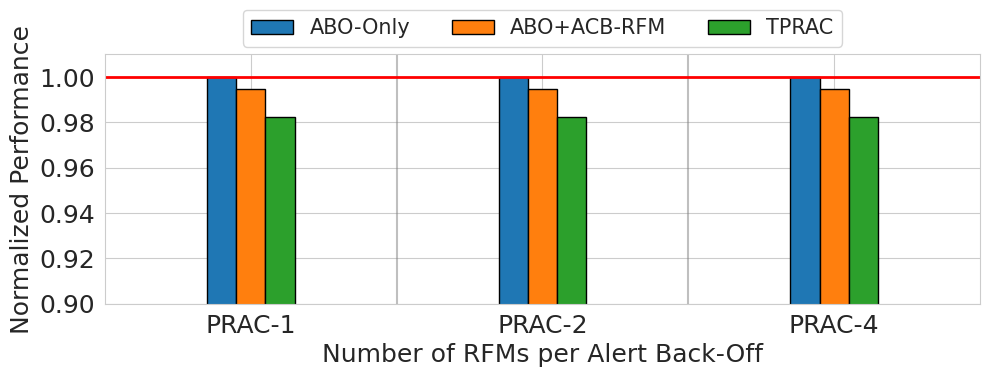

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm



df_prac_level_study = pd.read_csv('../stats/4cores_500M_TPRAC_S_Result_with_QPRAC.csv')
df_prac_level_study = df_prac_level_study[(df_prac_level_study['Nrh'] == 1024) & (df_prac_level_study['workload'] == 'All (90)')]

mitigation_interest = ["QPRAC-ABO-Only", 'QPRAC-BAT-RFM', 'QPRAC-TPRAC-S']

df_melted = pd.melt(
    df_prac_level_study, 
    id_vars=['workload', 'Benchmark_Types', 'Nrh', 'prac-level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
### For renaming mitigations
rename_mapping = {
    'QPRAC-ABO-Only': 'ABO-Only',
    'QPRAC-BAT-RFM': 'ABO+ACB-RFM',
    'QPRAC-TPRAC-S': 'TPRAC',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)
# Calculate performance overhead
df_melted['Performance_Overhead'] = (1 - df_melted['WS'])*100

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 4))
plt.rc('font', size=10)
# Use Seaborn's 'tab10' color palette
palette = sns.color_palette("tab10")
colors = {impl: palette[i % len(palette)] for i, impl in enumerate(df_melted['Mitigations'].unique())}


# Define bar width and x-tick positions
bar_width = 0.1  # Desired smaller bar width
x_ticks = [1, 2, 4]
num_bars = len(df_melted['Mitigations'].unique())
# Create a mapping for x-tick labels
x_tick_labels = {1: 'PRAC-1', 2: 'PRAC-2', 4: 'PRAC-4'}
# Calculate positions for bars
# x_tick_positions = np.arange(len(x_ticks))  # Positions for x-ticks
x_tick_positions = np.linspace(0, len(x_ticks) - 1, len(x_ticks))  # Adjust spacing here
bar_positions = {}

# Calculate bar positions
for idx, tick in enumerate(x_ticks):
    base_x = x_tick_positions[idx]
    bar_positions[tick] = [base_x - (bar_width * num_bars) / 2 + j * bar_width for j in range(num_bars)]

# Plot bars
for tick in x_ticks:
    subset = df_melted[df_melted['prac-level'] == tick]
    for i, prac_impl in enumerate(df_melted['Mitigations'].unique()):
        value = subset[subset['Mitigations'] == prac_impl]['WS'].values[0]
        x_position = bar_positions[tick][i] + bar_width / 2  # Adjust position for centering
        color = colors[prac_impl]
        ax.bar(x_position, value, width=bar_width, color=color, edgecolor='black', label=prac_impl if tick == x_ticks[0] else "")

# Add a horizontal line at y=1.0
# ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)

# Customize legend, labels, and ticks
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels from the legend
# ax.legend(by_label.values(), by_label.keys(), loc='best', ncol=3, fancybox=True, shadow=False, fontsize=16)

# Set xticks to specific num_RFM values and ensure correct spacing
ax.set_xticks(x_tick_positions)
ax.set_xticklabels([x_tick_labels[tick] for tick in x_ticks])  # Use mapped labels
ax.axvline(x=0.5, color='grey', linestyle='-', alpha=0.5)
ax.axvline(x=1.5, color='grey', linestyle='-', alpha=0.5)
ax.set_xlabel('Number of RFMs per Alert Back-Off', fontsize=18)
ax.set_ylabel('Normalized Performance', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=5, fancybox=True, shadow=False, fontsize=15)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
ax.set_yticks([0.9,0.92,0.94,0.96,0.98,1.0])
ax.set_ylim(0.9,1.01)
ax.set_xlim(-0.5, 2.5)

print(df_melted)

plt.tight_layout()
# plt.show()
fig.savefig('../plots/TPRAC_ISCA2025/TPRAC_prac_level_sensitivity.pdf', dpi=600, bbox_inches='tight')

     workload     Nrh  prac-level Benchmark_Types  QPRAC-ABO-Only  \
864  All (90)   256.0         1.0             NaN        0.999841   
867  All (90)   512.0         1.0             NaN        0.999977   
870  All (90)  1024.0         1.0             NaN        0.999993   
873  All (90)  2048.0         1.0             NaN        1.000000   
876  All (90)  4096.0         1.0             NaN        1.000000   

     QPRAC-BAT-RFM  QPRAC-TPRAC-S  
864       0.921173       0.860187  
867       0.971789       0.929712  
870       0.994513       0.982362  
873       0.997221       0.990952  
876       0.997221       0.990952  


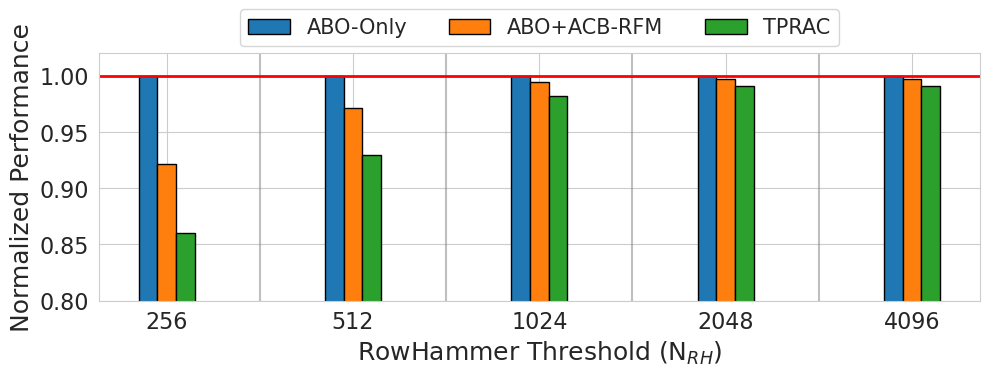

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm



df_prac_level_study = pd.read_csv('../stats/4cores_500M_TPRAC_S_Result_with_QPRAC.csv')
df_prac_level_study = df_prac_level_study[(df_prac_level_study['Nrh'].isin([256, 512, 1024, 2048, 4096])) &
                                          (df_prac_level_study['prac-level'] == 1) &
                                           (df_prac_level_study['workload'] == 'All (90)')]
print(df_prac_level_study)
mitigation_interest = ["QPRAC-ABO-Only", 'QPRAC-BAT-RFM', 'QPRAC-TPRAC-S']

df_melted = pd.melt(
    df_prac_level_study, 
    id_vars=['workload', 'Benchmark_Types', 'Nrh', 'prac-level'], 
    value_vars=mitigation_interest, 
    var_name='Mitigations', 
    value_name='WS'
)
### For renaming mitigations
rename_mapping = {
    'QPRAC-ABO-Only': 'ABO-Only',
    'QPRAC-BAT-RFM': 'ABO+ACB-RFM',
    'QPRAC-TPRAC-S': 'TPRAC',
}
# Replace the values in the PRAC_Implementation column
df_melted['Mitigations'] = df_melted['Mitigations'].replace(rename_mapping)
# Calculate performance overhead
df_melted['Performance_Overhead'] = (1 - df_melted['WS'])*100

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 4))
plt.rc('font', size=10)
# Use Seaborn's 'tab10' color palette
palette = sns.color_palette("tab10")
colors = {impl: palette[i % len(palette)] for i, impl in enumerate(df_melted['Mitigations'].unique())}


# Define bar width and x-tick positions
bar_width = 0.1  # Desired smaller bar width
x_ticks = [256, 512, 1024, 2048, 4096]
num_bars = len(df_melted['Mitigations'].unique())

x_tick_positions = np.linspace(0, len(x_ticks) - 1, len(x_ticks))  # Adjust spacing here
bar_positions = {}

# Calculate bar positions
for idx, tick in enumerate(x_ticks):
    base_x = x_tick_positions[idx]
    bar_positions[tick] = [base_x - (bar_width * num_bars) / 2 + j * bar_width for j in range(num_bars)]

# Plot bars
for tick in x_ticks:
    subset = df_melted[df_melted['Nrh'] == tick]
    for i, prac_impl in enumerate(df_melted['Mitigations'].unique()):
        value = subset[subset['Mitigations'] == prac_impl]['WS'].values[0]
        x_position = bar_positions[tick][i] + bar_width / 2  # Adjust position for centering
        color = colors[prac_impl]
        ax.bar(x_position, value, width=bar_width, color=color, edgecolor='black', label=prac_impl if tick == x_ticks[0] else "")

# Add a horizontal line at y=1.0
# ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
# Add vertical lines for better visual separation
trh_values = np.sort(df_melted['Nrh'].unique())
for i in range(len(trh_values) - 1):
    ax.axvline(x=i + 0.5, color='grey', linestyle='-', alpha=0.5)

# Customize legend, labels, and ticks
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels from the legend
# ax.legend(by_label.values(), by_label.keys(), loc='best', ncol=3, fancybox=True, shadow=False, fontsize=16)

# Set xticks to specific num_RFM values and ensure correct spacing
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_ticks)

ax.set_xlabel('RowHammer Threshold (N$_{RH}$)', fontsize=18)
ax.set_ylabel('Normalized Performance', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=5, fancybox=True, shadow=False, fontsize=15)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)

ax.set_ylim(0.8,1.02)
# ax.set_xlim(-0.5, 2.5)

plt.tight_layout()
# plt.show()
fig.savefig('../plots/TPRAC_ISCA2025/QPRAC_TPRAC_NRH_sensitivity.pdf', dpi=600, bbox_inches='tight')

**Energy Consumption**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from scipy.stats import gmean

multi_cores_out_path = '../../TPRAC_ISCA2025/4cores_results'

df = pd.DataFrame(columns=["mitigation", "workload"])
df_baseline = pd.DataFrame(columns=["mitigation", "workload"])

mitigation_list = ["Baseline", "ABO-Only", 'BAT-RFM', 'TPRAC-S']
for mitigation in mitigation_list:
    result_path = multi_cores_out_path + "/" + mitigation +"/stats/"
    result_list = [x[:-4] for x in os.listdir(result_path) if x.endswith(".txt")]
    for result_filename in result_list:
        result_file = open(result_path + result_filename + ".txt", "r")
        if mitigation in ['Baseline']:
            Channel = int(result_filename.split("_")[0])
            interface = int(result_filename.split("_")[1])
            workload = "_".join(result_filename.split("_")[2:])
        else:
            Channel = int(result_filename.split("_")[0])
            interface = int(result_filename.split("_")[1])
            NRH = int(result_filename.split("_")[2])
            if NRH == 128:
                continue
            PRAC_level = int(result_filename.split("_")[3])
            if PRAC_level != 1:
                continue
            workload = "_".join(result_filename.split("_")[4:])

        w0=''
        w1=''
        w2=''
        w3=''
        ipc_0 = 0
        ipc_1 = 0
        ipc_2 = 0
        ipc_3 = 0
        cycle_0 = 0
        cycle_1 = 0
        cycle_2 = 0
        cycle_3 = 0
        num_inst_0=0
        num_inst_1=0
        num_inst_2=0
        num_inst_3=0

        num_abo=0
        num_tREFI_period=0
        num_tREFW_period=0

        total_energy = 0.0
        qprac_dynamic_energy = 0.0
        qprac_static_energy = 0.0
        qprac_mitigation_energy = 0.0
        for line in result_file.readlines():
            if ("name_trace_0:" in line):
                w0 = str(line.split("/")[-1]).strip()
            if ("name_trace_1:" in line):
                w1 = str(line.split("/")[-1]).strip()
            if ("name_trace_2:" in line):
                w2 = str(line.split("/")[-1]).strip()
            if ("name_trace_3:" in line):
                w3 = str(line.split("/")[-1]).strip()
            if (" cycles_recorded_core_0:" in line):
                cycle_0 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_1:" in line):
                cycle_1 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_2:" in line):
                cycle_2 = int(line.split(" ")[-1])
            if (" cycles_recorded_core_3:" in line):
                cycle_3 = int(line.split(" ")[-1])
            if (" insts_recorded_core_0" in line):
                num_inst_0 = int(line.split(" ")[-1])
            if (" insts_recorded_core_1" in line):
                num_inst_1 = int(line.split(" ")[-1])
            if (" insts_recorded_core_2" in line):
                num_inst_2 = int(line.split(" ")[-1])
            if (" insts_recorded_core_3" in line):
                num_inst_3 = int(line.split(" ")[-1])
            if (" prac_num_recovery" in line):
                num_abo = int(line.split(" ")[-1])
            if (" num_refresh_command_0" in line):
                num_tREFI_period = int(line.split(" ")[-1])
            if (" num_refresh_window_0" in line):
                num_tREFW_period = int(line.split(" ")[-1])  
            if (" total_energy:" in line):
                total_energy = float(line.split(" ")[-1])   
            if (" qprac_mitigation_energy:" in line):
                qprac_mitigation_energy = float(line.split(" ")[-1])
            if (" qprac_static_energy:" in line):
                qprac_static_energy = float(line.split(" ")[-1])
            if (" qprac_dynamic_energy:" in line):
                qprac_dynamic_energy = float(line.split(" ")[-1])       
                
        if (cycle_0 == 0 and cycle_1 == 0 and cycle_2 == 0 and cycle_3 == 0):
            continue
        if (cycle_0 == 0 or cycle_1 == 0 or cycle_2 == 0 or cycle_3 == 0):
            print("Error: " + result_filename)
        ipc_0 = int(num_inst_0) / cycle_0
        ipc_1 = int(num_inst_1) / cycle_1
        ipc_2 = int(num_inst_2) / cycle_2
        ipc_3 = int(num_inst_3) / cycle_3
        
        result_file.close()
        total_energy += qprac_mitigation_energy
        mitigation_energy_rate = float(qprac_mitigation_energy/total_energy) * 100

        new_row = pd.DataFrame({
            'mitigation': [mitigation],
            'workload': [workload],
            'Nrh': [NRH],
            'Total Energy': [total_energy],
            "Mitigation Energy": [qprac_mitigation_energy],
            'ME Percentage': [mitigation_energy_rate]
        })
        df = pd.concat([df, new_row], ignore_index=True)

# print(df)

# Filter baseline data
baseline_data = df[df['mitigation'] == 'Baseline']

# Create a mapping of workload to baseline total energy
baseline_energy_map = baseline_data.set_index('workload')['Total Energy'].to_dict()
baseline_mitigation_energy_map = baseline_data.set_index('workload')['Mitigation Energy'].to_dict()

# Map baseline energy to the main dataframe
df['Baseline Energy'] = df['workload'].map(baseline_energy_map)
df['BaselineMitigation Energy'] = df['workload'].map(baseline_energy_map)

# Calculate normalized energy
df['Normalized Energy'] = df['Total Energy'] / df['Baseline Energy']
df['Normalized MitigationEnergy'] = df['Mitigation Energy'] / df['BaselineMitigation Energy']

# print(df)

# print(df[df['mitigation'] == 'TPRAC-S'])
df_energy = df.pivot(index=['workload', 'Nrh'], columns=['mitigation'], values='Normalized Energy').reset_index()
# print(df_energy)

# Group by Nrh and mitigation and calculate geomean for Normalized Energy
geomean_df = (
    df.groupby(['Nrh', 'mitigation'])['Normalized Energy']
    .apply(lambda x: gmean(x.dropna()))  # Compute geomean, dropping NaNs
    .reset_index()  # Flatten the grouped DataFrame
)

# Calculate the geometric mean for mitigation energy
geomean_mitigation_energy_df = (
    df.groupby(['Nrh', 'mitigation'])['Normalized MitigationEnergy']
    .apply(lambda x: gmean(x.dropna()))  # Compute geomean, dropping NaNs
    .reset_index()  # Flatten the grouped DataFrame
)

# Rename columns for clarity
geomean_mitigation_energy_df.rename(columns={'Normalized MitigationEnergy': 'Geomean Mitigation Energy'}, inplace=True)

# Filter out the 'Baseline' as it may not have mitigation energy
geomean_mitigation_energy_filtered = geomean_mitigation_energy_df[geomean_mitigation_energy_df['mitigation'] != 'Baseline']

# Print the filtered mitigation energy results
print(geomean_mitigation_energy_filtered)

# Rename columns for clarity
geomean_df.rename(columns={'Normalized Energy': 'Geomean Normalized Energy'}, inplace=True)

geomean_df_filtered = geomean_df[geomean_df['mitigation'] != 'Baseline']

print(geomean_df_filtered)
print(geomean_mitigation_energy_filtered)

       Nrh mitigation  Geomean Mitigation Energy
0    256.0   ABO-Only                   0.000000
1    256.0    BAT-RFM                   0.041347
2    256.0    TPRAC-S                   0.376380
3    512.0   ABO-Only                   0.000000
4    512.0    BAT-RFM                   0.013322
6    512.0    TPRAC-S                   0.164399
7   1024.0   ABO-Only                   0.000000
8   1024.0    BAT-RFM                   0.002352
9   1024.0    TPRAC-S                   0.038056
10  2048.0   ABO-Only                   0.000000
11  2048.0    BAT-RFM                   0.001076
12  2048.0    TPRAC-S                   0.018812
13  4096.0   ABO-Only                   0.000000
14  4096.0    BAT-RFM                   0.001076
15  4096.0    TPRAC-S                   0.018812
       Nrh mitigation  Geomean Normalized Energy
0    256.0   ABO-Only                   1.000533
1    256.0    BAT-RFM                   1.138146
2    256.0    TPRAC-S                   1.550001
3    512.0   ABO-Onl

mitigation     Nrh  ABO-Only   BAT-RFM   TPRAC-S
0            256.0  1.000533  1.138146  1.550001
1            512.0  1.000097  1.045407  1.246080
2           1024.0  1.000016  1.008298  1.056790
3           2048.0  1.000000  1.003496  1.028454
4           4096.0  1.000000  1.003496  1.028454


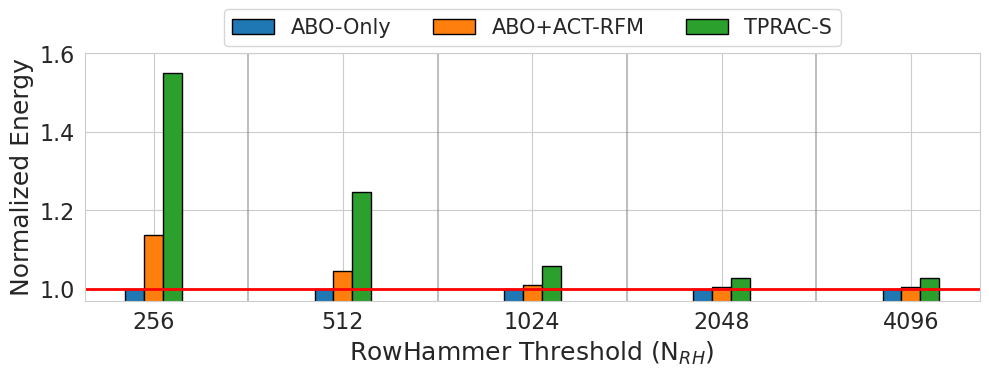

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.font_manager as fm


df_energy_result = geomean_df_filtered.pivot(index=['Nrh'], columns=['mitigation'], values='Geomean Normalized Energy').reset_index()

print(df_energy_result)
mitigation_interest = ["ABO-Only", 'BAT-RFM', 'TPRAC-S']

df_melted = pd.melt(
    df_energy_result, 
    id_vars=['Nrh'], 
    value_vars=mitigation_interest, 
    var_name='mitigation', 
    value_name='Geomean Normalized Energy'
)
### For renaming mitigations
rename_mapping = {
    'BAT-RFM': 'ABO+ACT-RFM',
}
# Replace the values in the PRAC_Implementation column
df_melted['mitigation'] = df_melted['mitigation'].replace(rename_mapping)
# Calculate performance overhead
# df_melted['Energy_Overhead'] = (df_melted['Geomean Normalized Energy'] - 1)*100

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 4))
plt.rc('font', size=10)
# Use Seaborn's 'tab10' color palette
palette = sns.color_palette("tab10")
colors = {impl: palette[i % len(palette)] for i, impl in enumerate(df_melted['mitigation'].unique())}


# Define bar width and x-tick positions
bar_width = 0.1  # Desired smaller bar width
x_ticks = [256, 512, 1024, 2048, 4096]
num_bars = len(df_melted['mitigation'].unique())

x_tick_positions = np.linspace(0, len(x_ticks) - 1, len(x_ticks))  # Adjust spacing here
bar_positions = {}

# Calculate bar positions
for idx, tick in enumerate(x_ticks):
    base_x = x_tick_positions[idx]
    bar_positions[tick] = [base_x - (bar_width * num_bars) / 2 + j * bar_width for j in range(num_bars)]

# Plot bars
for tick in x_ticks:
    subset = df_melted[df_melted['Nrh'] == tick]
    for i, prac_impl in enumerate(df_melted['mitigation'].unique()):
        value = subset[subset['mitigation'] == prac_impl]['Geomean Normalized Energy'].values[0]
        x_position = bar_positions[tick][i] + bar_width / 2  # Adjust position for centering
        color = colors[prac_impl]
        ax.bar(x_position, value, width=bar_width, color=color, edgecolor='black', label=prac_impl if tick == x_ticks[0] else "")

# Add a horizontal line at y=1.0
# ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)
# Add vertical lines for better visual separation
trh_values = np.sort(df_melted['Nrh'].unique())
for i in range(len(trh_values) - 1):
    ax.axvline(x=i + 0.5, color='grey', linestyle='-', alpha=0.5)

# Customize legend, labels, and ticks
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels from the legend
# ax.legend(by_label.values(), by_label.keys(), loc='best', ncol=3, fancybox=True, shadow=False, fontsize=16)

# Set xticks to specific num_RFM values and ensure correct spacing
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_ticks)

ax.set_xlabel('RowHammer Threshold (N$_{RH}$)', fontsize=18)
ax.set_ylabel('Normalized Energy', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=5, fancybox=True, shadow=False, fontsize=15)

ax.axhline(y=1.0, color='r', linestyle='-', linewidth=2)

ax.set_ylim(0.97,1.6)
# ax.set_xlim(-0.5, 2.5)

plt.tight_layout()
# plt.show()
fig.savefig('../plots/TPRAC_ISCA2025/QPRAC_TPRAC_energy_results.pdf', dpi=600, bbox_inches='tight')